# Sistema de Recomendação por Imagens com Deep Learning

**faiss-cpu**: biblioteca criada pelo Facebook para buscar vetores similares de forma rápida (usada em sistemas de recomendação).

**gradio**: para criar uma interface web simples, no estilo "appzinho", direto no Colab

In [ ]:
# Instalar dependências
!pip install -q faiss-cpu gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.3 MB/s eta 0:00:00


## 1. Upload e Descompactação do Dataset

In [ ]:
from google.colab import files
import zipfile, os

uploaded = files.upload()  # Envie o arquivo archive.zip

zip_path = "archive.zip"
extract_dir = "electronic-object-detection"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Arquivos extraídos para:", extract_dir)


Saving archive.zip to archive.zip
Arquivos extraídos para: electronic-object-detection


## 2. Carregar Caminhos das Imagens

In [ ]:
import os

image_paths = []
labels = []
for class_name in os.listdir(extract_dir):
    class_dir = os.path.join(extract_dir, class_name)
    for img_file in os.listdir(class_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(class_name)


## 3. Exibir Imagem de Exemplo

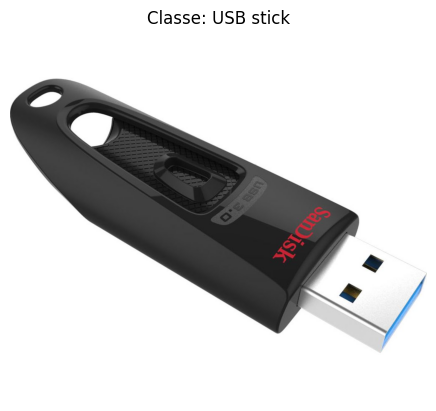

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

idx = 0
img = Image.open(image_paths[idx])
plt.imshow(img)
plt.title(f"Classe: {labels[idx]}")
plt.axis("off")
plt.show()


## 4. Carregar ResNet50 e Função de Preprocessamento

In [ ]:
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

IMG_SIZE = (224, 224)

def load_and_preprocess(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

model = ResNet50(weights='imagenet', include_top=False, pooling='avg')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


## 5. Extrair Vetores de Características (Embeddings)

In [ ]:
features = []
for path in tqdm(image_paths):
    img_tensor = load_and_preprocess(path)
    embedding = model.predict(img_tensor, verbose=0)
    features.append(embedding.flatten())

features = np.array(features).astype('float32')


  1%|          | 7/950 [00:10<13:11,  1.19it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 950/950 [01:51<00:00,  8.49it/s]


## 6. Criar o Índice FAISS para Similaridade

In [ ]:
import faiss

index = faiss.IndexFlatL2(features.shape[1])
index.add(features)


## 7. Interface Gradio para Recomendação

In [ ]:
import gradio as gr

def recommend_similar(img_input):
    img_input = img_input.resize(IMG_SIZE)
    img_array = image.img_to_array(img_input)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    embedding = model.predict(img_preprocessed, verbose=0)

    D, I = index.search(embedding, 6)
    similar_images = [Image.open(image_paths[i]) for i in I[0][1:]]  # Exclui a própria

    return similar_images

with gr.Blocks() as demo:
    with gr.Row():
        image_input = gr.Image(type="pil", label="Imagem de entrada")
        outputs = [gr.Image(type="pil", label=f"Similar {i+1}") for i in range(5)]

    image_input.change(fn=recommend_similar, inputs=image_input, outputs=outputs)

demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://68d966f0144173894b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# 8. Teste plotando as imagens

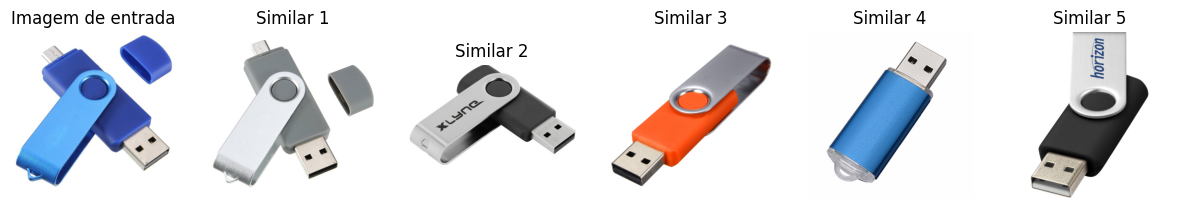

In [ ]:
import matplotlib.pyplot as plt

def show_similar_images(query_index, k=5):
    D, I = index.search(np.array([features[query_index]]), k+1)  # +1 para incluir a própria

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(I[0]):
        img = Image.open(image_paths[idx])
        plt.subplot(1, k+1, i+1)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title("Imagem de entrada")
        else:
            plt.title(f"Similar {i}")
    plt.show()

# Exemplo de uso:
show_similar_images(query_index=10)
